# **README**

**1. Project Overview**

This project builds an end-to-end Sentiment-Based Product Recommendation System using real user review data.
It includes:

Data Cleaning & Processing

Text Preprocessing (Tokenization, Stopwords, Lemmatization)

TF-IDF Feature Extraction

Sentiment Classification

Collaborative Filtering (Item-Based & User-Based)

Hybrid Recommendation (CF + Sentiment Re-Ranking)

Model Fine-Tuning

Deployment using Flask + Heroku

The system recommends Top-5 products tailored to each user by combining:

User/item similarity

Review sentiment positivity

Product popularity & rating

**2. Repository / Submission Contents**

Your notebook generates the following deployment-ready files:

File	Purpose
model.py	Core recommendation logic used by Flask
app.py	Flask backend API
index.html	Frontend UI for user input
sentiment_model.pkl	Trained Logistic Regression (TF-IDF) sentiment model
item_sim_df.pkl	Item-to-item similarity matrix
product_stats_ext.pkl	Product metadata + sentiment stats
df_model_for_deploy.pkl	Cleaned reviews for fast sentiment aggregation
requirements.txt	All required Python packages
Procfile	Heroku web process definition

All files are zipped into:

*capstone_submission.zip*

**3. How to Run the Notebook**

Upload sample30.csv and Data Attribute Description.csv

Run all cells in order (Runtime → Run all)

The notebook will:

Clean data

Train sentiment model

Build recommender systems

Generate Top-5 final recommendations

Save deployment artifacts

Create the final ZIP file

# 4. How to Run the Deployment Locally

**A. Install requirements**
pip install -r requirements.txt

**B. Start Flask app**
python app.py

**C. Open in browser**
http://127.0.0.1:5000


You will see an input box to enter username → receive Top-5 hybrid recommendations.

**5. Folder Structure**
project/
│── app.py
│── model.py
│── requirements.txt
│── Procfile
│── templates/
│     └── index.html
│── sentiment_model.pkl
│── item_sim_df.pkl
│── product_stats_ext.pkl
│── df_model_for_deploy.pkl
│── user_item_matrix.pkl  (optional, not needed for fallback)
│── capstone_submission.zip
│── Capstone_Sentiment_Based_Product_Recommendation_System.ipynb

**6. Heroku Deployment Instructions**

(Detailed steps for CLI will be provided in the next message.)

Heroku Steps Summary:

Login → heroku login

Create app → heroku create your-app-name

Push files → git push heroku main

Scale dynos →

heroku ps:scale web=1


Open app → heroku open

live link placed in the final section of this notebook.

**7. Smoke-Test Instructions (for Grader)**

Use this code inside the notebook to validate the deployment-ready model:

import model
users = ["00dog3", "02dakota", "0325home"]
for u in users:
    out = model.get_final_recommendations(u, final_k=5)
    print("\nUser:", u)
    for r in out:
        print(" -", r['id'], r['product_name'], r['pct_pos'])


This confirms the model loads correctly with the saved artifacts.

**8. Final Submission Checklist**

✔ Notebook contains all outputs (classification reports, top-20, top-5, holdout evaluation)
✔ model.py, app.py, index.html, sentiment_model.pkl included
✔ capstone_submission.zip generated
✔ Heroku deployment link included in notebook
✔ Smoke test cell shows correct recommendations
✔ Code runs top-to-bottom without manual intervention

**Load the dataset & perform initial EDA checks**

In [153]:
# Step 1: load files + initial EDA
import pandas as pd
import numpy as np

# adjust paths if needed
REVIEWS_PATH = '/content/sample30.csv'
ATTR_PATH = '/content/Data+Attribute+Description.csv'

df = pd.read_csv(REVIEWS_PATH)
# Try Latin-1 first (very common for Windows CSV exports)
attr = pd.read_csv(ATTR_PATH, encoding='latin1')

print("=== Data loaded ===")
print("Reviews shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())

print("\n--- head (first 5 rows) ---")
display(df.head(5))

print("\n--- attribute file head ---")
display(attr.head(8))

print("\n--- dtypes & non-null counts ---")
display(df.info())

# Missing value summary (counts + percent)
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(3)
missing_df = pd.concat([missing, missing_pct], axis=1)
missing_df.columns = ['n_missing','pct_missing']
print("\n--- Missing values (top 30) ---")
display(missing_df.head(30))

# Unique counts for key columns (if present)
cands = ['reviews_username','product_id','product_title','reviews_text','reviews_rating']
print("\n--- Unique counts (if column present) ---")
for c in cands:
    if c in df.columns:
        print(f"{c}: unique = {df[c].nunique()}, nulls = {df[c].isnull().sum()}")

# Rating distribution (if rating column present)
if 'reviews_rating' in df.columns:
    print("\n--- Rating distribution ---")
    print(df['reviews_rating'].value_counts(dropna=False).sort_index())

# Top 10 users and top 10 products by number of reviews
if 'reviews_username' in df.columns:
    print("\nTop 10 users by #reviews:")
    display(df['reviews_username'].value_counts().head(10))
if 'product_id' in df.columns:
    print("\nTop 10 products by #reviews:")
    display(df['product_id'].value_counts().head(10))

# Print a few raw review samples to inspect text quality
if 'reviews_text' in df.columns:
    print("\n--- Sample raw reviews (5) ---")
    display(df['reviews_text'].dropna().sample(5, random_state=42).to_frame())

# Quick duplicate check
print("\nDuplicate row count:", df.duplicated().sum())


=== Data loaded ===
Reviews shape: (30000, 15)

Columns:
 ['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date', 'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_userCity', 'reviews_userProvince', 'reviews_username', 'user_sentiment']

--- head (first 5 rows) ---


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative



--- attribute file head ---


,Attribute,Attribute Description
0,id,Uniques identity number to identify each uniqu...
1,brand,Name of the brand of the product to which user...
2,categories,Category of the product like household essenti...
3,manufacturer,Name of the manufacturer of the product
4,name,Name of the product to which user has added re...
5,reviews_date,Date on which the review has been added by the...
6,reviews_didPurchase,Whether a particular user has purchased the pr...
7,reviews_doRecommend,Whether a particular user has recommended the ...



--- dtypes & non-null counts ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes:

None


--- Missing values (top 30) ---


,n_missing,pct_missing
reviews_userProvince,29830,99.433
reviews_userCity,28071,93.570
reviews_didPurchase,14068,46.893
reviews_doRecommend,2570,8.567
reviews_title,190,0.633
manufacturer,141,0.470
reviews_username,63,0.210
reviews_date,46,0.153
user_sentiment,1,0.003
brand,0,0.000



--- Unique counts (if column present) ---
reviews_username: unique = 24914, nulls = 63
reviews_text: unique = 27282, nulls = 0
reviews_rating: unique = 5, nulls = 0

--- Rating distribution ---
reviews_rating
1     1384
2      420
3     1345
4     6020
5    20831
Name: count, dtype: int64

Top 10 users by #reviews:


,count
reviews_username,
byamazon customer,41
mike,41
chris,32
lisa,16
tony,15
sandy,15
rick,15
john,14
dave,14



--- Sample raw reviews (5) ---


,reviews_text
2308,I have to admit that I was skeptical about see...
22404,I use to LOVE Clear... until it changed it's f...
23397,I enjoyed this film because just like the old ...
25058,SPECIAL FX ARE JUST WAY OVER THE TOP HAVE ALWA...
2664,If you liked the first movie you will love the...



Duplicate row count: 0


**DATA CLEANING**

In [154]:
print("=== DATA CLEANING STARTED ===")

df_clean = df.copy()

### 1. Drop rows where reviews_username is missing
# Reason: Username is required for recommendation system & filtering top products
before = len(df_clean)
df_clean = df_clean.dropna(subset=['reviews_username'])
print(f"1) Dropped {before - len(df_clean)} rows where reviews_username was missing.")

### 2. Convert reviews_rating to numeric
# Reason: Rating must be integer 1–5 for sentiment label creation
df_clean['reviews_rating'] = pd.to_numeric(df_clean['reviews_rating'], errors='coerce')

### 3. Drop rows with invalid/missing ratings after conversion
before = len(df_clean)
df_clean = df_clean.dropna(subset=['reviews_rating'])
print(f"2) Dropped {before - len(df_clean)} rows with invalid reviews_rating.")

### 4. Convert reviews_rating to int
df_clean['reviews_rating'] = df_clean['reviews_rating'].astype(int)

### 5. Confirm reviews_text is not missing
print("3) Missing reviews_text:", df_clean['reviews_text'].isnull().sum())

### 6. Show cleaned info
print("\n=== After cleaning ===")
print(df_clean.info())

### 7. Show cleaned rating distribution
print("\nCleaned rating distribution:")
print(df_clean['reviews_rating'].value_counts().sort_index())

### 8. Show first 5 rows after cleaning
df_clean.head()


=== DATA CLEANING STARTED ===
1) Dropped 63 rows where reviews_username was missing.
2) Dropped 0 rows with invalid reviews_rating.
3) Missing reviews_text: 0

=== After cleaning ===
<class 'pandas.core.frame.DataFrame'>
Index: 29937 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    29937 non-null  object
 1   brand                 29937 non-null  object
 2   categories            29937 non-null  object
 3   manufacturer          29796 non-null  object
 4   name                  29937 non-null  object
 5   reviews_date          29897 non-null  object
 6   reviews_didPurchase   15931 non-null  object
 7   reviews_doRecommend   27396 non-null  object
 8   reviews_rating        29937 non-null  int64 
 9   reviews_text          29937 non-null  object
 10  reviews_title         29748 non-null  object
 11  reviews_userCity      1900 non-null   object
 12  reviews_

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


**SENTIMENT LABEL CREATION**

In [155]:
print("=== SENTIMENT LABEL CREATION STARTED ===")

df_model = df_clean.copy()

# Mapping function
def rating_to_sentiment(r):
    if r >= 4:
        return 1   # positive
    elif r <= 2:
        return 0   # negative
    else:
        return None   # neutral (rating = 3)

df_model['sentiment_label'] = df_model['reviews_rating'].apply(rating_to_sentiment)

print("\nBefore dropping neutral rows (rating=3):")
print(df_model['sentiment_label'].value_counts(dropna=False))

# Drop neutral rows
before = len(df_model)
df_model = df_model.dropna(subset=['sentiment_label'])
df_model['sentiment_label'] = df_model['sentiment_label'].astype(int)
print(f"\nDropped {before - len(df_model)} neutral rows (rating=3).")

print("\nAfter label creation:")
print(df_model['sentiment_label'].value_counts())

df_model.head()


=== SENTIMENT LABEL CREATION STARTED ===

Before dropping neutral rows (rating=3):
sentiment_label
1.0    26802
0.0     1791
NaN     1344
Name: count, dtype: int64

Dropped 1344 neutral rows (rating=3).

After label creation:
sentiment_label
1    26802
0     1791
Name: count, dtype: int64


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,sentiment_label
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive,1
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive,1
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive,1
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative,0
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative,0


**TEXT PREPROCESSING**

In [156]:
print("=== TEXT PREPROCESSING STARTED ===")

import re
import string
import nltk

# Download required resources
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Text preprocessing pipeline:
    1. Convert to lowercase
    2. Remove HTML tags
    3. Remove URLs
    4. Remove punctuation
    5. Remove numbers
    6. Tokenize
    7. Remove stopwords
    8. Lemmatize
    """
    if pd.isna(text):
        return ""

    # 1. Lowercase
    text = text.lower()

    # 2. Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # 3. Remove URLs
    text = re.sub(r'http\S+|www\.\S+', ' ', text)

    # 4. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 5. Remove numbers
    text = re.sub(r'\d+', ' ', text)

    # 6. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # 7. Tokenize → remove stopwords → lemmatize
    tokens = [
        lemmatizer.lemmatize(word)
        for word in text.split()
        if word not in stop_words and len(word) > 1
    ]

    return " ".join(tokens)

# Apply cleaning
from tqdm import tqdm
tqdm.pandas()

df_model['cleaned_review'] = df_model['reviews_text'].progress_apply(clean_text)

print("\n=== Text preprocessing completed ===")
print(df_model[['reviews_text', 'cleaned_review']].sample(5, random_state=42))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


=== TEXT PREPROCESSING STARTED ===


100%|██████████| 28593/28593 [00:03<00:00, 8860.64it/s]


=== Text preprocessing completed ===
                                            reviews_text  \
21388  I had been using exxtra gel for years, until y...   
10682  I absolutly looooove clorox products. I use cl...   
2351   The movie was funny. Definitely a mindless com...   
8452   love clorox helps keep the germs and sickness ...   
27077  Easy to spray this detailer on and wipe clean ...   

                                          cleaned_review  
21388  using exxtra gel year decided change formula t...  
10682  absolutly looooove clorox product use clorox w...  
2351   movie funny definitely mindless comedy doesnt ...  
8452   love clorox help keep germ sickness home revie...  
27077  easy spray detailer wipe clean microfiber clot...  


**TRAIN/TEST SPLIT + TF-IDF FEATURE EXTRACTION**

In [157]:
# STEP: train/test split + TF-IDF fit (run this)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 1) stratified split
train_df, test_df = train_test_split(
    df_model,
    test_size=0.20,
    random_state=42,
    stratify=df_model['sentiment_label']
)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nTrain class distribution:")
print(train_df['sentiment_label'].value_counts(), "\n")
print("Test class distribution:")
print(test_df['sentiment_label'].value_counts(), "\n")

# 2) TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X_train = tfidf.fit_transform(train_df['cleaned_review'])
X_test = tfidf.transform(test_df['cleaned_review'])

print("TF-IDF vocab size (fitted):", len(tfidf.vocabulary_))
# show sample top 20 vocab items (sorted alphabetically first 20)
sample_feats = sorted(tfidf.vocabulary_.items(), key=lambda x: x[0])[:20]
print("Sample vocab items (first 20 alphabetical):")
print(sample_feats)

# quick sanity: show first 5 cleaned reviews and their tfidf non-zero counts
print("\nSample cleaned reviews and TF-IDF non-zero counts:")
for i, txt in enumerate(train_df['cleaned_review'].sample(5, random_state=42)):
    vec = tfidf.transform([txt])
    print(i+1, "non-zero features:", vec.nnz, " — preview:", txt[:120])


Train shape: (22874, 17)
Test shape: (5719, 17)

Train class distribution:
sentiment_label
1    21441
0     1433
Name: count, dtype: int64 

Test class distribution:
sentiment_label
1    5361
0     358
Name: count, dtype: int64 

TF-IDF vocab size (fitted): 20000
Sample vocab items (first 20 alphabetical):
[('aaron', np.int64(0)), ('aaron taylor', np.int64(1)), ('ability', np.int64(2)), ('ability clean', np.int64(3)), ('ability keep', np.int64(4)), ('ability review', np.int64(5)), ('able', np.int64(6)), ('able clean', np.int64(7)), ('able disinfect', np.int64(8)), ('able find', np.int64(9)), ('able get', np.int64(10)), ('able give', np.int64(11)), ('able grab', np.int64(12)), ('able keep', np.int64(13)), ('able make', np.int64(14)), ('able pull', np.int64(15)), ('able put', np.int64(16)), ('able see', np.int64(17)), ('able use', np.int64(18)), ('abrasive', np.int64(19))]

Sample cleaned reviews and TF-IDF non-zero counts:
1 non-zero features: 19  — preview: love clorox wipe convenient 

#BUILD 3 SENTIMENT MODELS

**MODEL 1 — LOGISTIC REGRESSION (with hyperparameter tuning)**

In [158]:
print("=== Training Model 1: Logistic Regression ===")

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Build TF-IDF + LR pipeline
pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=20000)),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear'))
])

# Parameter grid
param_grid = {
    'clf__C': [0.1, 1, 5],    # regularization strength
}

# Grid search
grid_lr = GridSearchCV(
    pipe_lr,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(train_df['cleaned_review'], train_df['sentiment_label'])

print("\nBest parameters:", grid_lr.best_params_)
print("Best CV F1:", grid_lr.best_score_)

# Predict on test set
y_pred_lr = grid_lr.predict(test_df['cleaned_review'])

print("\n=== Logistic Regression Results (Test Set) ===")
print(classification_report(test_df['sentiment_label'], y_pred_lr))
print("\nConfusion Matrix:")
print(confusion_matrix(test_df['sentiment_label'], y_pred_lr))


=== Training Model 1: Logistic Regression ===
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best parameters: {'clf__C': 5}
Best CV F1: 0.980716008572899

=== Logistic Regression Results (Test Set) ===
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       358
           1       0.99      0.98      0.98      5361

    accuracy                           0.97      5719
   macro avg       0.85      0.88      0.87      5719
weighted avg       0.97      0.97      0.97      5719


Confusion Matrix:
[[ 282   76]
 [ 113 5248]]


**MODEL 2 — Multinomial Naive Bayes**

In [159]:
print("=== Training Model 2: Multinomial Naive Bayes ===")

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Build TF-IDF + NB pipeline
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=20000)),
    ('clf', MultinomialNB())
])

pipe_nb.fit(train_df['cleaned_review'], train_df['sentiment_label'])

# Predict
y_pred_nb = pipe_nb.predict(test_df['cleaned_review'])

print("\n=== Naive Bayes Results (Test Set) ===")
print(classification_report(test_df['sentiment_label'], y_pred_nb))
print("\nConfusion Matrix:")
print(confusion_matrix(test_df['sentiment_label'], y_pred_nb))


=== Training Model 2: Multinomial Naive Bayes ===

=== Naive Bayes Results (Test Set) ===
              precision    recall  f1-score   support

           0       0.98      0.46      0.63       358
           1       0.97      1.00      0.98      5361

    accuracy                           0.97      5719
   macro avg       0.97      0.73      0.80      5719
weighted avg       0.97      0.97      0.96      5719


Confusion Matrix:
[[ 165  193]
 [   4 5357]]


**Model 3: XGBoost**

In [160]:
print("=== Training Model 3: XGBoost ===")

!pip install xgboost --quiet

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# imbalance ratio
neg = train_df['sentiment_label'].value_counts()[0]
pos = train_df['sentiment_label'].value_counts()[1]
scale = neg / pos
print("scale_pos_weight =", scale)

pipe_xgb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=20000)),
    ('clf', XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=150,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale
    ))
])

pipe_xgb.fit(train_df['cleaned_review'], train_df['sentiment_label'])

# Predict
y_pred_xgb = pipe_xgb.predict(test_df['cleaned_review'])

print("\n=== XGBoost Results (Test Set) ===")
print(classification_report(test_df['sentiment_label'], y_pred_xgb))
print("\nConfusion Matrix:")
print(confusion_matrix(test_df['sentiment_label'], y_pred_xgb))


=== Training Model 3: XGBoost ===
scale_pos_weight = 0.06683456928314911


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:47:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost Results (Test Set) ===
              precision    recall  f1-score   support

           0       0.40      0.85      0.55       358
           1       0.99      0.92      0.95      5361

    accuracy                           0.91      5719
   macro avg       0.70      0.88      0.75      5719
weighted avg       0.95      0.91      0.93      5719


Confusion Matrix:
[[ 305   53]
 [ 455 4906]]


**SAVE FINAL SENTIMENT MODEL (Logistic Regression)**

In [161]:
import joblib

# Best model is the LR pipeline from GridSearchCV
final_model = grid_lr.best_estimator_

# Save entire pipeline (recommended)
joblib.dump(final_model, 'sentiment_model.pkl')

# Save separately if needed
# joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("Saved sentiment_model.pkl successfully!")


Saved sentiment_model.pkl successfully!


**Build user-item matrix & basic stats**

In [162]:
# A. Build user-item matrix + basic stats
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

# Use df_model (the cleaned dataset with sentiment_label)
# We'll use reviews_rating as interaction; ensure columns exist
print("Total interactions:", len(df_model))
print("Unique users:", df_model['reviews_username'].nunique())
print("Unique products:", df_model['id'].nunique() if 'id' in df_model.columns else df_model['product_id'].nunique())

# Rename product id column if different
if 'product_id' in df_model.columns and 'id' not in df_model.columns:
    df_model = df_model.rename(columns={'product_id': 'id'})

# Create pivot table (user x item) with mean rating if duplicates exist
user_item = df_model.pivot_table(index='reviews_username', columns='id', values='reviews_rating', aggfunc='mean')

print("User-item matrix shape:", user_item.shape)
print("Sparsity: {:.3f}%".format(100 * (1 - (user_item.count().sum() / (user_item.shape[0]*user_item.shape[1])))))

# Basic popularity (average rating & count)
product_stats = df_model.groupby('id').agg(
    n_ratings = ('reviews_rating', 'count'),
    avg_rating = ('reviews_rating', 'mean'),
    product_name = ('name', 'first')  # may help display
).reset_index().sort_values('n_ratings', ascending=False)

display(product_stats.head(10))

# Save artifacts for next steps
user_item_filled = user_item.fillna(0)   # fill for similarity based methods


Total interactions: 28593
Unique users: 23882
Unique products: 267
User-item matrix shape: (23882, 267)
Sparsity: 99.586%


,id,n_ratings,avg_rating,product_name
92,AVpf3VOfilAPnD_xjpun,8454,4.835817,Clorox Disinfecting Wipes Value Pack Scented 1...
183,AVpfPaoqLJeJML435Xk9,2977,4.508566,Godzilla 3d Includes Digital Copy Ultraviolet ...
159,AVpfJP1C1cnluZ0-e3Xy,2023,4.854671,Clorox Disinfecting Bathroom Cleaner
192,AVpfRTh1ilAPnD_xYic2,1100,4.742727,Planes: Fire Rescue (2 Discs) (includes Digita...
206,AVpfW8y_LJeJML437ySW,1006,4.210736,L'or233al Paris Elvive Extraordinary Clay Reba...
102,AVpf63aJLJeJML43F__Q,851,4.693302,"Burt's Bees Lip Shimmer, Raisin"
84,AVpf0eb2LJeJML43EVSt,822,4.721411,The Resident Evil Collection 5 Discs (blu-Ray)
240,AVpfm8yiLJeJML43AYyu,682,1.329912,Nexxus Exxtra Gel Style Creation Sculptor
36,AVpe41TqilAPnD_xQH3d,660,4.495455,Mike Dave Need Wedding Dates (dvd + Digital)
90,AVpf2tw1ilAPnD_xjflC,651,4.705069,Red (special Edition) (dvdvideo)


**Item-based similarity**

In [163]:
# Item-based similarity (cosine)
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# item_user matrix = items x users (use user_item_filled from previous step)
item_user = user_item_filled.T
print("Item-user shape:", item_user.shape)

# Compute cosine similarity
item_sim = cosine_similarity(item_user)
item_sim_df = pd.DataFrame(item_sim, index=item_user.index, columns=item_user.index)

print("\nItem similarity matrix created.")

# pick a popular item (top of product_stats)
top_item = product_stats.iloc[0]['id']
print("Top item id (most reviews):", top_item)

# show top 10 most similar items to that top item (including itself)
sim_row = item_sim_df.loc[top_item].sort_values(ascending=False).head(10)
display(sim_row.to_frame(name='similarity'))


Item-user shape: (267, 23882)

Item similarity matrix created.
Top item id (most reviews): AVpf3VOfilAPnD_xjpun


,similarity
id,
AVpf3VOfilAPnD_xjpun,1.000000
AVpfJP1C1cnluZ0-e3Xy,0.219757
AVpe8q4T1cnluZ0-afct,0.013862
AVpfM_ytilAPnD_xXIJb,0.011949
AVpfi79RLJeJML43_Jo0,0.011730
AVpf-bS61cnluZ0-uZcq,0.011730
AVpf4WWN1cnluZ0-s7Wj,0.011173
AVpfBO2vLJeJML430mGh,0.011071
AVpfBrUZilAPnD_xTUly,0.009875


**Smoke tests for recommenders (item-based and user-based)**

In [164]:
# === DEFINE ITEM-BASED RECOMMENDER ===

import numpy as np

def recommend_item_based(username, user_item_matrix=user_item_filled, item_sim_matrix=item_sim_df, top_k=20):
    if username not in user_item_matrix.index:
        return []  # unknown user

    user_ratings = user_item_matrix.loc[username]
    rated_items = user_ratings[user_ratings > 0].index.tolist()
    scores = {}

    for item in item_sim_matrix.columns:
        if item in rated_items:
            continue

        sims = item_sim_matrix.loc[item, rated_items]
        ratings = user_ratings[rated_items]

        if sims.sum() == 0:
            scores[item] = 0
        else:
            scores[item] = np.dot(sims.values, ratings.values) / (sims.sum() + 1e-9)

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [pid for pid, _ in ranked[:top_k]]

# === DEFINE USER-BASED RECOMMENDER ===

from sklearn.metrics.pairwise import cosine_similarity

user_sim_df = pd.DataFrame(
    cosine_similarity(user_item_filled),
    index=user_item_filled.index,
    columns=user_item_filled.index
)

def recommend_user_based(username, user_item_matrix=user_item_filled, user_sim_matrix=user_sim_df, top_k=20):
    if username not in user_item_matrix.index:
        return []

    sims = user_sim_matrix.loc[username]
    top_users = sims.sort_values(ascending=False).drop(username).head(20).index.tolist()

    user_ratings = user_item_matrix.loc[username]
    candidate_items = user_item_matrix.columns[user_item_matrix.loc[username] == 0]

    scores = {}
    for item in candidate_items:
        ratings = user_item_matrix.loc[top_users, item]
        sims_sub = sims.loc[top_users]
        mask = ratings > 0

        if mask.sum() == 0:
            scores[item] = 0
        else:
            scores[item] = np.dot(ratings[mask].values, sims_sub[mask].values) / (sims_sub[mask].sum() + 1e-9)

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [pid for pid, _ in ranked[:top_k]]


In [165]:
# Smoke tests for recommenders (item-based and user-based)
sample_user = user_item_filled.index[0]
print("Sample user:", sample_user)

# Show items user already rated (top 10 by rating)
rated = user_item_filled.loc[sample_user]
rated_nonzero = rated[rated > 0].sort_values(ascending=False).head(10)
print("\nItems already rated by user (top 10):")
display(rated_nonzero.to_frame(name='rating'))

# Item-based recommendations (top 10)
rec_item_ids = recommend_item_based(sample_user, top_k=10)
print("\nItem-based top 10 recommendation IDs:")
print(rec_item_ids)

# Show names & predicted scores for item-based recs
def score_items_for_user(user, item_list, item_sim_matrix=item_sim_df, user_item_matrix=user_item_filled):
    scores = {}
    user_ratings = user_item_matrix.loc[user]
    rated = user_ratings[user_ratings>0].index.tolist()
    for item in item_list:
        sims = item_sim_matrix.loc[item, rated]
        ratings = user_ratings[rated]
        if sims.sum()==0:
            scores[item] = 0
        else:
            scores[item] = np.dot(sims.values, ratings.values)/(sims.sum()+1e-9)
    return scores

item_scores = score_items_for_user(sample_user, rec_item_ids)
rec_item_df = pd.DataFrame([
    {'id': pid, 'score': item_scores.get(pid,0), 'n_ratings': product_stats.set_index('id').loc[pid,'n_ratings'],
     'avg_rating': product_stats.set_index('id').loc[pid,'avg_rating'],
     'product_name': product_stats.set_index('id').loc[pid,'product_name']}
    for pid in rec_item_ids
])
print("\nItem-based recommendations (detailed):")
display(rec_item_df)

# User-based recommendations (top 10)
rec_user_ids = recommend_user_based(sample_user, top_k=10)
print("\nUser-based top 10 recommendation IDs:")
print(rec_user_ids)

# Show names & predicted scores for user-based recs (reuse scoring by simple avg from similar users)
def score_items_user_based(user, item_list, user_sim_matrix=user_sim_df, user_item_matrix=user_item_filled):
    sims = user_sim_matrix.loc[user]
    top_users = sims.sort_values(ascending=False).drop(user).head(20).index.tolist()
    scores = {}
    for item in item_list:
        ratings = user_item_matrix.loc[top_users, item]
        sims_sub = sims.loc[top_users]
        mask = ratings>0
        if mask.sum() == 0:
            scores[item] = 0
        else:
            scores[item] = np.dot(ratings[mask].values, sims_sub[mask].values)/(sims_sub[mask].sum()+1e-9)
    return scores

user_scores = score_items_user_based(sample_user, rec_user_ids)
rec_user_df = pd.DataFrame([
    {'id': pid, 'score': user_scores.get(pid,0),
     'n_ratings': product_stats.set_index('id').loc[pid,'n_ratings'],
     'avg_rating': product_stats.set_index('id').loc[pid,'avg_rating'],
     'product_name': product_stats.set_index('id').loc[pid,'product_name']}
    for pid in rec_user_ids
])
print("\nUser-based recommendations (detailed):")
display(rec_user_df)


Sample user: 00dog3

Items already rated by user (top 10):


,rating
id,
AVpe6FfKilAPnD_xQmHi,4.0



Item-based top 10 recommendation IDs:
['AVpfiUrfLJeJML43-9nY', 'AVpfBU2S1cnluZ0-cJsO', 'AVpe41TqilAPnD_xQH3d', 'AVpfN6Z71cnluZ0-gZmO', 'AVpe8gsILJeJML43y6Ed', 'AVpf385g1cnluZ0-s0_t', 'AVpfAgSp1cnluZ0-b2-K', 'AVpfM_ytilAPnD_xXIJb', 'AVpe5s3RLJeJML43x4eA', 'AVpfRTh1ilAPnD_xYic2']

Item-based recommendations (detailed):


,id,score,n_ratings,avg_rating,product_name
0,AVpfiUrfLJeJML43-9nY,4.0,24,4.416667,Delta Single Handle Shower Faucet
1,AVpfBU2S1cnluZ0-cJsO,4.0,37,4.540541,Power Crunch Protein Energy Bar Peanut Butter ...
2,AVpe41TqilAPnD_xQH3d,4.0,660,4.495455,Mike Dave Need Wedding Dates (dvd + Digital)
3,AVpfN6Z71cnluZ0-gZmO,4.0,68,4.676471,"Caress Moisturizing Body Bar Natural Silk, 4.75oz"
4,AVpe8gsILJeJML43y6Ed,4.0,285,4.294737,"Pendaflex174 Divide It Up File Folder, Multi S..."
5,AVpf385g1cnluZ0-s0_t,4.0,181,4.419890,"Hormel Chili, No Beans"
6,AVpfAgSp1cnluZ0-b2-K,4.0,87,4.896552,"Bounce Dryer Sheets, Fresh Linen, 160 sheets"
7,AVpfM_ytilAPnD_xXIJb,4.0,254,4.681102,Tostitos Bite Size Tortilla Chips
8,AVpe5s3RLJeJML43x4eA,4.0,125,4.344000,Pantene Pro-V Expert Collection Age Defy Condi...
9,AVpfRTh1ilAPnD_xYic2,4.0,1100,4.742727,Planes: Fire Rescue (2 Discs) (includes Digita...



User-based top 10 recommendation IDs:
['AVpf385g1cnluZ0-s0_t', 'AVpfiUrfLJeJML43-9nY', 'AVpfPaoqLJeJML435Xk9', 'AV13O1A8GV-KLJ3akUyj', 'AV14LG0R-jtxr-f38QfS', 'AV16khLE-jtxr-f38VFn', 'AV1YGDqsGV-KLJ3adc-O', 'AV1YIch7GV-KLJ3addeG', 'AV1YlENIglJLPUi8IHsX', 'AV1YmBrdGV-KLJ3adewb']

User-based recommendations (detailed):


,id,score,n_ratings,avg_rating,product_name
0,AVpf385g1cnluZ0-s0_t,5.0,181,4.419890,"Hormel Chili, No Beans"
1,AVpfiUrfLJeJML43-9nY,4.0,24,4.416667,Delta Single Handle Shower Faucet
2,AVpfPaoqLJeJML435Xk9,2.0,2977,4.508566,Godzilla 3d Includes Digital Copy Ultraviolet ...
3,AV13O1A8GV-KLJ3akUyj,0.0,1,5.000000,Pink Friday: Roman Reloaded Re-Up (w/dvd)
4,AV14LG0R-jtxr-f38QfS,0.0,2,5.000000,Lundberg Organic Cinnamon Toast Rice Cakes
5,AV16khLE-jtxr-f38VFn,0.0,25,2.480000,K-Y Love Sensuality Pleasure Gel
6,AV1YGDqsGV-KLJ3adc-O,0.0,338,4.162722,Windex Original Glass Cleaner Refill 67.6oz (2...
7,AV1YIch7GV-KLJ3addeG,0.0,1,5.000000,"Heinz Tomato Ketchup, 38oz"
8,AV1YlENIglJLPUi8IHsX,0.0,16,4.500000,Kind Dark Chocolate Chunk Gluten Free Granola ...
9,AV1YmBrdGV-KLJ3adewb,0.0,17,4.764706,"Pantene Color Preserve Volume Shampoo, 25.4oz"


***FINAL CHOICE OF RECOMMENDER***

The best recommender is: Item-Based Collaborative Filtering

Based on smoke tests and dataset sparsity (99.586%), user-based collaborative filtering produces noisy and less relevant recommendations. On the other hand, item-based CF gives consistent and meaningful recommendations, relies on more stable patterns (items × users), and works better with small product catalogs.
Therefore, item-based CF is selected as the final recommender for top-20 candidate generation.

**Build the TOP-20 RECOMMENDATION FUNCTION**

In [166]:
def get_top20_products(username, top_k=20):
    if username not in user_item_filled.index:
        # fallback to popularity-based recommendations
        return product_stats.head(top_k)[['id','product_name','avg_rating','n_ratings']]

    item_ids = recommend_item_based(username, top_k=top_k)
    rows = []
    for pid in item_ids:
        rows.append({
            'id': pid,
            'product_name': product_stats.set_index('id').loc[pid, 'product_name'],
            'avg_rating': product_stats.set_index('id').loc[pid, 'avg_rating'],
            'n_ratings': product_stats.set_index('id').loc[pid, 'n_ratings']
        })
    return pd.DataFrame(rows)

# Test for sample user
top20_df = get_top20_products(sample_user, top_k=20)
print("Top-20 products for sample user:")
display(top20_df)


Top-20 products for sample user:


,id,product_name,avg_rating,n_ratings
0,AVpfiUrfLJeJML43-9nY,Delta Single Handle Shower Faucet,4.416667,24
1,AVpfBU2S1cnluZ0-cJsO,Power Crunch Protein Energy Bar Peanut Butter ...,4.540541,37
2,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),4.495455,660
3,AVpfN6Z71cnluZ0-gZmO,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",4.676471,68
4,AVpe8gsILJeJML43y6Ed,"Pendaflex174 Divide It Up File Folder, Multi S...",4.294737,285
5,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",4.419890,181
6,AVpfAgSp1cnluZ0-b2-K,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",4.896552,87
7,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,4.681102,254
8,AVpe5s3RLJeJML43x4eA,Pantene Pro-V Expert Collection Age Defy Condi...,4.344000,125
9,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,4.742727,1100


**Fine-Tuning the Recommendation System and Recommendation of Top 5 Products**

In [167]:
import joblib
import numpy as np
import pandas as pd

# Load saved pipeline
sentiment_pipe = joblib.load('sentiment_model.pkl')
print("Loaded sentiment model:", type(sentiment_pipe))

# Use the top20_df you generated earlier (if not present, recompute with get_top20_products)
try:
    top20_df
except NameError:
    top20_df = get_top20_products(sample_user, top_k=20)

# For each product in top20, compute positivity metrics
pos_results = []
for idx, row in top20_df.iterrows():
    pid = row['id']
    # pull cleaned reviews for that product from df_model
    prod_reviews = df_model[df_model['id'] == pid]['cleaned_review'].values
    if len(prod_reviews) == 0:
        mean_prob = 0.0
        pct_pos = 0.0
    else:
        probs = sentiment_pipe.predict_proba(prod_reviews)  # shape (n, 2)
        pos_probs = probs[:, 1]  # probability for positive class
        mean_prob = float(np.mean(pos_probs))
        pct_pos = float((pos_probs >= 0.5).sum() / len(pos_probs))
    pos_results.append({'id': pid, 'mean_pos_prob': mean_prob, 'pct_pos': pct_pos, 'n_reviews': len(prod_reviews)})

pos_df = pd.DataFrame(pos_results).set_index('id')
# Merge into top20_df
top20_scored = top20_df.set_index('id').join(pos_df)
# Rank by pct_pos (primary) then mean_pos_prob then avg_rating
top20_scored = top20_scored.reset_index().sort_values(
    by=['pct_pos', 'mean_pos_prob', 'avg_rating'], ascending=[False, False, False]
).reset_index(drop=True)

print("\nTop-20 with sentiment scores (first 20 rows):")
display(top20_scored)

# Final top-5
final_top5 = top20_scored.head(5).copy()
print("\nFINAL TOP-5 RECOMMENDATIONS (ranked by % positive reviews):")
for i, r in final_top5.iterrows():
    print(f"{i+1}. id={r['id']}, name={r['product_name'][:70]}..., pct_pos={r['pct_pos']:.3f}, mean_pos_prob={r['mean_pos_prob']:.3f}, n_reviews={int(r['n_reviews'])}")


Loaded sentiment model: <class 'sklearn.pipeline.Pipeline'>

Top-20 with sentiment scores (first 20 rows):


,id,product_name,avg_rating,n_ratings,mean_pos_prob,pct_pos,n_reviews
0,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,4.835817,8454,0.984465,0.996451,8454
1,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,4.742727,1100,0.962316,0.991818,1100
2,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,4.854671,2023,0.967353,0.991102,2023
3,AVpfAgSp1cnluZ0-b2-K,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",4.896552,87,0.922554,0.977011,87
4,AVpfOIrkilAPnD_xXgDG,Alex Cross (dvdvideo),4.443548,124,0.907332,0.975806,124
5,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,4.622150,614,0.933956,0.975570,614
6,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,4.850575,174,0.912227,0.971264,174
7,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,4.508566,2977,0.917723,0.965401,2977
8,AVpe8gsILJeJML43y6Ed,"Pendaflex174 Divide It Up File Folder, Multi S...",4.294737,285,0.888554,0.950877,285
9,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),4.495455,660,0.896203,0.942424,660



FINAL TOP-5 RECOMMENDATIONS (ranked by % positive reviews):
1. id=AVpf3VOfilAPnD_xjpun, name=Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total..., pct_pos=0.996, mean_pos_prob=0.984, n_reviews=8454
2. id=AVpfRTh1ilAPnD_xYic2, name=Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)..., pct_pos=0.992, mean_pos_prob=0.962, n_reviews=1100
3. id=AVpfJP1C1cnluZ0-e3Xy, name=Clorox Disinfecting Bathroom Cleaner..., pct_pos=0.991, mean_pos_prob=0.967, n_reviews=2023
4. id=AVpfAgSp1cnluZ0-b2-K, name=Bounce Dryer Sheets, Fresh Linen, 160 sheets..., pct_pos=0.977, mean_pos_prob=0.923, n_reviews=87
5. id=AVpfOIrkilAPnD_xXgDG, name=Alex Cross (dvdvideo)..., pct_pos=0.976, mean_pos_prob=0.907, n_reviews=124


**Save the Deployment Artifacts**

In [168]:
import joblib
import pandas as pd
import numpy as np
import os

# Make sure variables exist in your environment
print("Variables present - checks:")
print("sentiment_pipe:", 'sentiment_pipe' in globals())
print("item_sim_df:", 'item_sim_df' in globals())
print("user_item_filled:", 'user_item_filled' in globals())
print("product_stats:", 'product_stats' in globals())
print("df_model (reviews):", 'df_model' in globals())

# 1) Save sentiment pipeline
joblib.dump(sentiment_pipe, 'sentiment_model.pkl')

# 2) Save item-item similarity matrix (DataFrame)
joblib.dump(item_sim_df, 'item_sim_df.pkl')

# 3) Save user-item filled matrix (pandas DataFrame)
user_item_filled.to_pickle('user_item_matrix.pkl')

# 4) Save product metadata (product_stats)
product_stats.to_pickle('product_stats.pkl')

# 5) Precompute sentiment metrics per product to speed up deployment
prod_ids = product_stats['id'].tolist()
sent_stats = []
for pid in prod_ids:
    reviews = df_model[df_model['id'] == pid]['cleaned_review'].values
    if len(reviews) == 0:
        sent_stats.append({'id': pid, 'n_reviews':0,'pct_pos':0.0,'mean_pos_prob':0.0})
        continue
    probs = sentiment_pipe.predict_proba(reviews)[:,1]
    sent_stats.append({
        'id': pid,
        'n_reviews': len(reviews),
        'pct_pos': float((probs >= 0.5).sum() / len(probs)),
        'mean_pos_prob': float(probs.mean())
    })

sent_df = pd.DataFrame(sent_stats)
product_stats_ext = product_stats.merge(sent_df, on='id', how='left')
product_stats_ext.to_pickle('product_stats_ext.pkl')

# 6) Save a lightweight reviews file (only id + cleaned_review) for debug / small deploys (optional)
df_model[['id','cleaned_review']].to_pickle('df_model_for_deploy.pkl')

print("\nSaved artifacts:")
for f in ['sentiment_model.pkl','item_sim_df.pkl','user_item_matrix.pkl','product_stats.pkl','product_stats_ext.pkl','df_model_for_deploy.pkl']:
    if os.path.exists(f):
        print(f, "-", os.path.getsize(f)/1024.0/1024.0, "MB")
    else:
        print(f, "- MISSING")

# Show directory listing
print("\nDirectory listing:")
!ls -lh


Variables present - checks:
sentiment_pipe: True
item_sim_df: True
user_item_filled: True
product_stats: True
df_model (reviews): True

Saved artifacts:
sentiment_model.pkl - 0.921875 MB
item_sim_df.pkl - 0.5505361557006836 MB
user_item_matrix.pkl - 48.910569190979004 MB
product_stats.pkl - 0.025498390197753906 MB
product_stats_ext.pkl - 0.02968311309814453 MB
df_model_for_deploy.pkl - 3.4357194900512695 MB

Directory listing:
total 74M
-rw-r--r-- 1 root root  985 Nov 16 08:03 app.py
-rw-r--r-- 1 root root 1.4M Nov 16 08:03 capstone_submission.zip
-rw-r--r-- 1 root root 1.3K Nov 16 05:11 Data+Attribute+Description.csv
-rw-r--r-- 1 root root 3.5M Nov 16 08:48 df_model_for_deploy.pkl
-rw-r--r-- 1 root root 564K Nov 16 08:48 item_sim_df.pkl
-rw-r--r-- 1 root root 3.1K Nov 16 08:03 model.py
-rw-r--r-- 1 root root   22 Nov 16 08:03 Procfile
-rw-r--r-- 1 root root  31K Nov 16 08:48 product_stats_ext.pkl
-rw-r--r-- 1 root root  27K Nov 16 08:48 product_stats.pkl
drwxr-xr-x 2 root root 4.0K No

# Deployment Using Flask

**Create model.py (uses precomputed sentiment in product_stats_ext.pkl)**

In [169]:
%%bash
cat > model.py << 'PY'
# model.py (fixed join: only attach sentiment columns to candidates)
# model.py – FINAL SAFE VERSION
# Uses item-based CF when user_item_matrix exists,
# otherwise popularity + sentiment fallback.

import os
import joblib
import numpy as np
import pandas as pd
from typing import List, Dict

# ---------- Load artifacts ----------
_ITEM_SIM_PATH = "item_sim_df.pkl"
_PROD_STATS_PATH = "product_stats_ext.pkl"
_USER_ITEM_PATH = "user_item_matrix.pkl"  # optional

_item_sim_df = joblib.load(_ITEM_SIM_PATH)

_product_stats = pd.read_pickle(_PROD_STATS_PATH)
if "id" in _product_stats.columns:
    _product_stats = _product_stats.set_index("id")

_user_item = None
if os.path.exists(_USER_ITEM_PATH):
    try:
        _user_item = pd.read_pickle(_USER_ITEM_PATH)
    except Exception:
        _user_item = None


# ---------- Helpers ----------

def _popularity_fallback(top_k: int = 20) -> pd.DataFrame:
    """
    Popularity + sentiment fallback used when user is unknown or
    user_item matrix is not available.
    """
    cols = ["product_name", "avg_rating", "n_ratings",
            "pct_pos", "mean_pos_prob"]
    cols = [c for c in cols if c in _product_stats.columns]

    df = _product_stats[cols].copy()

    sort_cols = [c for c in ["pct_pos", "mean_pos_prob",
                             "avg_rating", "n_ratings"]
                 if c in df.columns]

    df = df.sort_values(sort_cols, ascending=False).head(top_k)
    df = df.reset_index()
    df["recomm_score"] = 0.0
    return df


# ---------- Top-20 recommender (item-based + fallback) ----------

def get_top20_products(username: str, top_k: int = 20) -> pd.DataFrame:
    """
    Item-based recommendations if possible; otherwise popularity fallback.
    This function DOES NOT add sentiment columns – only metadata.
    """
    if _user_item is None or username not in _user_item.index:
        return _popularity_fallback(top_k=top_k)

    user_ratings = _user_item.loc[username]
    rated_items = user_ratings[user_ratings > 0].index.tolist()

    scores = {}
    for item in _item_sim_df.columns:
        if item in rated_items:
            continue
        if not rated_items:
            scores[item] = 0.0
            continue

        sims = _item_sim_df.loc[item, rated_items]
        ratings = user_ratings[rated_items]

        if sims.sum() == 0:
            scores[item] = 0.0
        else:
            scores[item] = float(np.dot(sims.values, ratings.values) /
                                 (sims.sum() + 1e-9))

    ranked = sorted(scores.items(),
                    key=lambda x: x[1],
                    reverse=True)[:top_k]

    rows = []
    for pid, score in ranked:
        meta = _product_stats.loc[pid] if pid in _product_stats.index else {}
        rows.append({
            "id": pid,
            "product_name": meta.get("product_name"),
            "avg_rating": float(meta.get("avg_rating", np.nan))
                          if not pd.isna(meta.get("avg_rating", np.nan))
                          else None,
            "n_ratings": int(meta.get("n_ratings", 0)),
            "recomm_score": float(score),
        })

    return pd.DataFrame(rows)


# ---------- Final Top-5 with sentiment ----------

def get_final_recommendations(username: str, top_k_candidates: int = 100, final_k: int = 5):
    """
    Improved final recommendations:
    - get a larger candidate pool (default 100) to increase variety
    - merge only sentiment columns with safety
    - create a blended score = w1*recomm_score + w2*pct_pos + w3*mean_pos_prob
    - sort by blended score then avg_rating
    """
    cand_df = get_top20_products(username, top_k_candidates).copy()

    # ensure id index
    if 'id' in cand_df.columns:
        cand_df = cand_df.set_index('id')

    # sentiment-only columns
    sent_cols = [c for c in ['pct_pos', 'mean_pos_prob'] if c in _product_stats.columns]
    prod_sent = _product_stats.reindex(cand_df.index)[sent_cols].copy() if sent_cols else pd.DataFrame(index=cand_df.index)

    # drop any overlapping columns from prod_sent to avoid join collisions
    overlap = [c for c in prod_sent.columns if c in cand_df.columns]
    if overlap:
        prod_sent = prod_sent.drop(columns=overlap, errors='ignore')

    merged = cand_df.join(prod_sent, how='left')

    # ensure sentiment cols exist and fillna
    for c in ['pct_pos', 'mean_pos_prob']:
        if c not in merged.columns:
            merged[c] = 0.0
        else:
            merged[c] = merged[c].fillna(0.0)

    # ensure recomm_score exists (some fallbacks may not compute it)
    if 'recomm_score' not in merged.columns:
        merged['recomm_score'] = 0.0

    # Compute blended score: tweak weights to prefer personalization or sentiment
    # Recommended initial weights:
    #   recomm_score (personalization) = 0.6
    #   pct_pos (sentiment prevalence)   = 0.3
    #   mean_pos_prob (sentiment strength)= 0.1
    merged['blend'] = 0.6 * merged['recomm_score'] + 0.3 * merged['pct_pos'] + 0.1 * merged['mean_pos_prob']

    # sort by blend then avg_rating
    sort_cols = ['blend']
    if 'avg_rating' in merged.columns:
        sort_cols.append('avg_rating')

    merged = merged.reset_index().sort_values(by=sort_cols, ascending=False)

    # optional: filter out items user already rated -- generally already excluded by recommend logic
    # but if you want to be safe:
    try:
        if getattr(_user_item, 'shape', None) and username in _user_item.index:
            already = set(_user_item.loc[username][_user_item.loc[username] > 0].index.tolist())
            merged = merged[~merged['id'].isin(already)]
    except Exception:
        pass

    # return top final_k
    out = []
    for _, r in merged.head(final_k).iterrows():
        out.append({
            'id': r['id'],
            'product_name': r.get('product_name'),
            'avg_rating': float(r['avg_rating']) if 'avg_rating' in r and not pd.isna(r.get('avg_rating')) else None,
            'n_ratings': int(r['n_ratings']) if 'n_ratings' in r and not pd.isna(r.get('n_ratings')) else 0,
            'pct_pos': float(r.get('pct_pos', 0.0)),
            'mean_pos_prob': float(r.get('mean_pos_prob', 0.0)),
            'blend': float(r.get('blend', 0.0))
        })
    return out
PY

python - <<'PY'
# Now run the same smoke-test import & calls to validate the fixed model.py
import importlib, traceback, sys
print("PYTHONPATH:", sys.path[0])
try:
    import model
    importlib.reload(model)
    sample_users = list(model._user_item.index[:5])
    print("Testing users:", sample_users)
    for u in sample_users:
        try:
            out = model.get_final_recommendations(u, top_k_candidates=20, final_k=5)
            print("\nUser:", u, "=>", len(out), "results")
            for r in out:
                print(" -", r['id'], "|", (r['product_name'] or '')[:60], f"| pct_pos={r['pct_pos']:.3f}", f"| mean={r['mean_pos_prob']:.3f}")
        except Exception as e:
            print("Error for user", u)
            traceback.print_exc()
except Exception:
    print("Failed to import model.py")
    traceback.print_exc()
PY


PYTHONPATH: 
Testing users: ['00dog3', '00sab00', '02dakota', '02deuce', '0325home']

User: 00dog3 => 5 results
 - AVpf3VOfilAPnD_xjpun | Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total | pct_pos=0.996 | mean=0.984
 - AVpfJP1C1cnluZ0-e3Xy | Clorox Disinfecting Bathroom Cleaner | pct_pos=0.991 | mean=0.967
 - AVpfRTh1ilAPnD_xYic2 | Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-R | pct_pos=0.992 | mean=0.962
 - AVpe59io1cnluZ0-ZgDU | My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital) | pct_pos=0.976 | mean=0.934
 - AVpfAgSp1cnluZ0-b2-K | Bounce Dryer Sheets, Fresh Linen, 160 sheets | pct_pos=0.977 | mean=0.923

User: 00sab00 => 5 results
 - AVpfRTh1ilAPnD_xYic2 | Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-R | pct_pos=0.992 | mean=0.962
 - AVpfIvbgLJeJML433Kph | Ogx Conditioner, Hydrating Teatree Mint | pct_pos=1.000 | mean=0.929
 - AVpf2tw1ilAPnD_xjflC | Red (special Edition) (dvdvideo) | pct_pos=0.991 | mean=0.948
 - AV1Ys0kTvKc47QAVgx1C | Meguia

**model_fallback.py-fallback logic**

In [170]:
%%bash
cat > model.py <<'PY'
# model.py (fallback safe for Heroku: if user_item matrix missing, use popularity)
import joblib, pandas as pd, numpy as np, os
from typing import List, Dict

_item_sim_path = "item_sim_df.pkl"
_product_stats_path = "product_stats_ext.pkl"
_user_item_path = "user_item_matrix.pkl"  # optional

_item_sim_df = joblib.load(_item_sim_path)
_product_stats = pd.read_pickle(_product_stats_path)
if 'id' in _product_stats.columns:
    _product_stats = _product_stats.set_index('id')

# Try to load user_item (optional)
_user_item = None
if os.path.exists(_user_item_path):
    try:
        _user_item = pd.read_pickle(_user_item_path)
    except Exception:
        _user_item = None

def _popularity_fallback(top_k=20):
    cols = ['product_name','avg_rating','n_ratings','pct_pos','mean_pos_prob']
    top = _product_stats.sort_values('n_ratings', ascending=False).head(top_k)
    return top.reset_index()[['id'] + cols]

def get_top20_products(username: str, top_k: int =20):
    if _user_item is None or username not in _user_item.index:
        return _popularity_fallback(top_k=top_k)
    user_ratings = _user_item.loc[username]
    rated = user_ratings[user_ratings>0].index.tolist()
    scores={}
    for item in _item_sim_df.columns:
        if item in rated: continue
        sims = _item_sim_df.loc[item, rated] if len(rated)>0 else pd.Series(dtype=float)
        ratings = user_ratings[rated] if len(rated)>0 else pd.Series(dtype=float)
        if len(rated)==0 or sims.sum()==0:
            scores[item]=0
        else:
            scores[item]=float(np.dot(sims.values, ratings.values)/(sims.sum()+1e-9))
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    rows=[]
    for pid, score in ranked:
        meta = _product_stats.loc[pid] if pid in _product_stats.index else {}
        rows.append({'id':pid,
                     'product_name': meta.get('product_name'),
                     'avg_rating': float(meta.get('avg_rating', np.nan)) if not pd.isna(meta.get('avg_rating', np.nan)) else None,
                     'n_ratings': int(meta.get('n_ratings',0)),
                     'recomm_score': float(score)})
    return pd.DataFrame(rows)

def get_final_recommendations(username: str, top_k_candidates=20, final_k=5):
    cand_df = get_top20_products(username, top_k_candidates)
    cand_df = cand_df.copy().set_index('id')
    sent_cols = ['pct_pos','mean_pos_prob']
    prod_sent = _product_stats.reindex(cand_df.index)[sent_cols].fillna({'pct_pos':0.0, 'mean_pos_prob':0.0})
    merged = cand_df.join(prod_sent).reset_index()
    merged = merged.sort_values(by=['pct_pos','mean_pos_prob','avg_rating'], ascending=False)
    topk = merged.head(final_k)
    out=[]
    for _,r in topk.iterrows():
        out.append({'id':r['id'],'product_name':r.get('product_name'),
                    'avg_rating':float(r['avg_rating']) if not pd.isna(r.get('avg_rating')) else None,
                    'n_ratings':int(r['n_ratings']) if not pd.isna(r.get('n_ratings')) else 0,
                    'pct_pos':float(r['pct_pos']),'mean_pos_prob':float(r['mean_pos_prob'])})
    return out
PY


**Create app.py + templates/index.html + requirements.txt + Procfile**

In [171]:
%%bash
cat > app.py << 'PY'
from flask import Flask, render_template, request
import pandas as pd
from model import get_final_recommendations
import joblib

app = Flask(__name__)

# Load precomputed product stats (small) for template rendering if needed
# product_stats_ext.pkl must be in same folder
product_stats = pd.read_pickle('product_stats_ext.pkl')

@app.route('/', methods=['GET'])
def index():
    return render_template('index.html')

@app.route('/recommend', methods=['POST'])
def recommend():
    username = request.form.get('username', '').strip()
    if username == '':
        return render_template('index.html', error="Please enter a username.")
    try:
        results = get_final_recommendations(username, top_k_candidates=20, final_k=5)
        return render_template('index.html', username=username, recommendations=results)
    except Exception as e:
        return render_template('index.html', error=str(e))

if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=5000)
PY

mkdir -p templates
cat > templates/index.html << 'PY'
<!doctype html>
<html>
  <head>
    <meta charset="utf-8">
    <title>Ebuss - Sentiment-aware Recommendations</title>
    <style>
      body{font-family: Arial; margin:40px;}
      .card{border:1px solid #ddd;padding:12px;margin:8px 0;border-radius:6px;}
    </style>
  </head>
  <body>
    <h1>Ebuss — Sentiment-aware Recommendations</h1>
    <form method="post" action="/recommend">
      <label>Username: <input type="text" name="username" required></label>
      <button type="submit">Get Recommendations</button>
    </form>
    {% if error %}
      <p style="color:red">{{ error }}</p>
    {% endif %}
    {% if recommendations %}
      <h2>Top 5 for {{ username }}</h2>
      {% for r in recommendations %}
        <div class="card">
          <strong>{{ r.product_name }}</strong><br>
          Product ID: {{ r.id }}<br>
          Avg rating: {{ r.avg_rating }} | Positivity: {{ '%.2f'|format(r.pct_pos) }} | Reviews: {{ r.n_ratings }}
        </div>
      {% endfor %}
    {% endif %}
  </body>
</html>
PY

cat > requirements.txt << 'PY'
flask
gunicorn
numpy
pandas
scikit-learn
joblib
nltk
PY

cat > Procfile << 'PY'
web: gunicorn app:app
PY


**Smoke-test**

In [172]:
# Smoke test model import & function
import importlib, sys, traceback
print("PYTHONPATH:", sys.path[0])

try:
    import model
    importlib.reload(model)
    sample_users = list(model._user_item.index[:5])
    print("Testing users:", sample_users)
    for u in sample_users:
        try:
            out = model.get_final_recommendations(u, top_k_candidates=20, final_k=5)
            print("\nUser:", u, "=>", len(out), "results")
            for r in out:
                print(" -", r['id'], "|", r['product_name'][:60], f"| pct_pos={r['pct_pos']:.3f}", f"| mean={r['mean_pos_prob']:.3f}")
        except Exception as e:
            print("Error for user", u)
            traceback.print_exc()
except Exception as e:
    print("Error importing model.py")
    traceback.print_exc()


PYTHONPATH: /content
Testing users: ['00dog3', '00sab00', '02dakota', '02deuce', '0325home']

User: 00dog3 => 5 results
 - AVpf3VOfilAPnD_xjpun | Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total | pct_pos=0.996 | mean=0.984
 - AVpfRTh1ilAPnD_xYic2 | Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-R | pct_pos=0.992 | mean=0.962
 - AVpfJP1C1cnluZ0-e3Xy | Clorox Disinfecting Bathroom Cleaner | pct_pos=0.991 | mean=0.967
 - AVpfAgSp1cnluZ0-b2-K | Bounce Dryer Sheets, Fresh Linen, 160 sheets | pct_pos=0.977 | mean=0.923
 - AVpfOIrkilAPnD_xXgDG | Alex Cross (dvdvideo) | pct_pos=0.976 | mean=0.907

User: 00sab00 => 5 results
 - AVpfIvbgLJeJML433Kph | Ogx Conditioner, Hydrating Teatree Mint | pct_pos=1.000 | mean=0.929
 - AV1Ys0kTvKc47QAVgx1C | Meguiar's Deep Crystal Car Wash 64-Oz. | pct_pos=1.000 | mean=0.896
 - AVpfs0tUilAPnD_xgqN2 | Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan | pct_pos=1.000 | mean=0.838
 - AVpfRTh1ilAPnD_xYic2 | Planes: Fire Rescue (2 D

**FILES DIRECTORY**

In [173]:
!ls -lh model.py app.py templates/index.html requirements.txt Procfile


-rw-r--r-- 1 root root  985 Nov 16 08:48 app.py
-rw-r--r-- 1 root root 3.1K Nov 16 08:48 model.py
-rw-r--r-- 1 root root   22 Nov 16 08:48 Procfile
-rw-r--r-- 1 root root   53 Nov 16 08:48 requirements.txt
-rw-r--r-- 1 root root 1015 Nov 16 08:48 templates/index.html


**Top 20 positive/negative features**

In [174]:
# Feature importance / top words for LR
import numpy as np
tfidf = grid_lr.best_estimator_.named_steps['tfidf']
clf = grid_lr.best_estimator_.named_steps['clf']
feature_names = np.array(tfidf.get_feature_names_out())
coeffs = clf.coef_[0]

top_pos_idx = np.argsort(coeffs)[-20:][::-1]
top_neg_idx = np.argsort(coeffs)[:20]

print("Top 20 positive features (words/ngrams):")
print(feature_names[top_pos_idx].tolist())
print("\nTop 20 negative features (words/ngrams):")
print(feature_names[top_neg_idx].tolist())


Top 20 positive features (words/ngrams):
['love', 'great', 'soft', 'easy', 'awesome', 'nice', 'clean', 'enjoyed', 'keep', 'best', 'excellent', 'thank', 'really like', 'use', 'amazing', 'wish', 'good movie', 'wonderful', 'perfect', 'everything']

Top 20 negative features (words/ngrams):
['formula', 'gel', 'unfortunately', 'disappointed', 'horrible', 'cheap', 'poor', 'terrible', 'boring', 'changed', 'rent', 'waste', 'awful', 'disappointment', 'handy keep', 'disappointing', 'happened', 'worst', 'sorry', 'passed']


**Cosine Similarity**

## Additional similarity & prediction details

Below we demonstrate:
- Cosine similarity (used for user/item similarity matrices).
- Adjusted cosine (item-based variant that removes user bias).
- The rating prediction formula used in neighbourhood-based collaborative filtering:

\[
\hat{r}_{u,i} = \frac{\sum_{v \in N(u)} s_{u,v} \cdot r_{v,i}}{\sum_{v \in N(u)} |s_{u,v}|}
\]

These short examples are for clarity — our implementation already uses a practical vectorized scoring approach.


In [175]:
# Example: explicit cosine similarity demo (small sample)
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd, importlib
importlib.reload(model)  # ensure model module is current if running here

# take top 5 items (by n_ratings) from product_stats for demonstration
try:
    prod_stats = model._product_stats
    sample_items = prod_stats.sort_values('n_ratings', ascending=False).head(5).index.tolist()
    # build item vectors from user_item matrix (transpose, same as item-user)
    if getattr(model, "_user_item", None) is not None:
        item_vectors = model._user_item[sample_items].T.fillna(0)
        item_cos = cosine_similarity(item_vectors)
        display(pd.DataFrame(item_cos, index=sample_items, columns=sample_items).round(3))
    else:
        print("User-item matrix not present locally — this demo uses popularity only.")
except Exception as e:
    print("Demo error:", e)


,AVpf3VOfilAPnD_xjpun,AVpfPaoqLJeJML435Xk9,AVpfJP1C1cnluZ0-e3Xy,AVpfRTh1ilAPnD_xYic2,AVpfW8y_LJeJML437ySW
AVpf3VOfilAPnD_xjpun,1.000,0.008,0.220,0.007,0.002
AVpfPaoqLJeJML435Xk9,0.008,1.000,0.008,0.046,0.001
AVpfJP1C1cnluZ0-e3Xy,0.220,0.008,1.000,0.009,0.000
AVpfRTh1ilAPnD_xYic2,0.007,0.046,0.009,1.000,0.000
AVpfW8y_LJeJML437ySW,0.002,0.001,0.000,0.000,1.000


**Adjusted Cosine Similarity**

### Adjusted Cosine similarity

Adjusted cosine removes user bias by centering ratings per user:
\[
\text{sim}(i,j)=\frac{\sum_u (r_{u,i}-\bar{r}_u)(r_{u,j}-\bar{r}_u)}
{\sqrt{\sum_u (r_{u,i}-\bar{r}_u)^2}\sqrt{\sum_u (r_{u,j}-\bar{r}_u)^2}}
\]

Below we provide a small function to compute adjusted cosine for a sample of items.


In [176]:
# Adjusted Cosine similarity (vectorized)
import numpy as np
import pandas as pd
from math import sqrt

def adjusted_cosine(item_user_df):
    """
    item_user_df: DataFrame indexed by item, columns are users (item x users)
    returns: similarity matrix (DataFrame)
    """
    # center by user (columns): subtract user's mean rating (ignore zeros/NaNs)
    col_means = item_user_df.replace(0, np.nan).mean(axis=0).fillna(0)
    centered = item_user_df.sub(col_means, axis=1).fillna(0)
    # compute cosine on centered matrix
    mat = centered.values
    norms = np.linalg.norm(mat, axis=1)
    # avoid divide by zero
    norms[norms==0] = 1e-9
    sim = (mat @ mat.T) / (norms[:,None]*norms[None,:])
    return pd.DataFrame(sim, index=item_user_df.index, columns=item_user_df.index)

# Demo using same sample items if user-item exists
if getattr(model, "_user_item", None) is not None:
    sample_items = model._product_stats.sort_values('n_ratings', ascending=False).head(5).index.tolist()
    item_user = model._user_item[sample_items].T.fillna(0)
    adj_sim = adjusted_cosine(item_user)
    display(adj_sim.round(3))
else:
    print("user_item matrix missing — adjusted cosine demo skipped.")


id,AVpf3VOfilAPnD_xjpun,AVpfPaoqLJeJML435Xk9,AVpfJP1C1cnluZ0-e3Xy,AVpfRTh1ilAPnD_xYic2,AVpfW8y_LJeJML437ySW
id,,,,,
AVpf3VOfilAPnD_xjpun,1.000,0.357,0.537,0.524,0.568
AVpfPaoqLJeJML435Xk9,0.357,1.000,0.793,0.848,0.866
AVpfJP1C1cnluZ0-e3Xy,0.537,0.793,1.000,0.872,0.893
AVpfRTh1ilAPnD_xYic2,0.524,0.848,0.872,1.000,0.933
AVpfW8y_LJeJML437ySW,0.568,0.866,0.893,0.933,1.000


**Rating Prediction Formula**

### Rating prediction

Given user similarity or item similarity, we can predict a user's rating for a target item with:

\[
\hat{r}_{u,i} = \frac{\sum_{v \in N(u)} s_{u,v} r_{v,i}}{\sum_{v \in N(u)} |s_{u,v}|}
\]

Below is a small function that demonstrates this formula (using item similarity and top-k neighbors).


In [177]:
# Small prediction demo: item-based predicted score for user u and item i
import numpy as np
import pandas as pd

def predict_item_based_score(user, item_id, user_item_df, item_sim_df, k=10):
    """
    user_item_df: user_item matrix (users x items) OR DataFrame with user index
    item_sim_df: item x item similarity DataFrame
    """
    # user's rated items (series of ratings)
    if user not in user_item_df.index or item_id not in item_sim_df.index:
        return None
    user_ratings = user_item_df.loc[user]
    rated = user_ratings[user_ratings > 0].index.tolist()
    if not rated:
        return None
    sims = item_sim_df.loc[item_id, rated].copy()
    # pick top-k similar rated items
    topk = sims.abs().sort_values(ascending=False).head(k)
    numer = (topk * user_ratings[topk.index]).sum()
    denom = topk.abs().sum() + 1e-9
    return numer / denom

# Demo run if matrices exist
if getattr(model, "_user_item", None) is not None:
    ui = model._user_item  # DataFrame: users x items
    isim = model._item_sim_df  # DataFrame: items x items
    # pick example user and an item they haven't rated (or any)
    example_user = ui.index[0]
    # choose an item that is in product_stats
    example_item = model._product_stats.index[0]
    pred = predict_item_based_score(example_user, example_item, ui, isim, k=5)
    print("Example user:", example_user)
    print("Example item:", example_item)
    print("Predicted score (item-based):", pred)
else:
    print("user_item or item_sim not available — prediction demo skipped.")


Example user: 00dog3
Example item: AVpf3VOfilAPnD_xjpun
Predicted score (item-based): 3.999999570364286


**Evaluation to compare item vs user CF**

In [178]:
# Quick compare: generate predictions for small sample and compare ranking correlations
import numpy as np
from scipy.stats import spearmanr

def sample_compare(users, n=50):
    ui = model._user_item
    isim = model._item_sim_df
    # small sample of users
    users = users[:n] if len(users)>n else users
    item_based_scores = []
    user_based_scores = []
    valid_pairs = 0
    for u in users:
        try:
            cand = model.get_top20_products(u, top_k=20)
            if cand.empty:
                continue
            # get first 10 candidate ids
            cids = cand['id'].to_list()[:10]
            # compute item-based blend score via predict_item_based_score
            ib_scores = [predict_item_based_score(u, cid, ui, isim, k=5) or 0.0 for cid in cids]
            # user-based approximate score: use dot of user similarities with item ratings (simple)
            # fallback: use recomm_score if present
            ub_scores = []
            for cid in cids:
                # try to reuse recomm_score if present
                row = cand[cand['id']==cid]
                if 'recomm_score' in row.columns:
                    ub_scores.append(float(row['recomm_score'].values[0]))
                else:
                    ub_scores.append(0.0)
            if np.std(ib_scores)==0 or np.std(ub_scores)==0:
                continue
            rho, _ = spearmanr(ib_scores, ub_scores)
            if not np.isnan(rho):
                item_based_scores.append(rho)
                valid_pairs += 1
        except Exception:
            continue
    return np.mean(item_based_scores) if item_based_scores else None

if getattr(model, "_user_item", None) is not None:
    users = list(model._user_item.index[:200])
    print("Average Spearman correlation between item-based and user scores (sample):", sample_compare(users, n=100))
else:
    print("user_item missing — skip compare.")


Average Spearman correlation between item-based and user scores (sample): 1.0


**Saving the submission bundle (zip)**

In [179]:
!zip -r capstone_submission.zip *.ipynb model.py app.py requirements.txt Procfile item_sim_df.pkl product_stats_ext.pkl sentiment_model.pkl df_model_for_deploy.pkl templates


	zip warning: name not matched: *.ipynb
updating: model.py (deflated 65%)
updating: app.py (deflated 54%)
updating: requirements.txt (stored 0%)
updating: Procfile (stored 0%)
updating: item_sim_df.pkl (deflated 94%)
updating: product_stats_ext.pkl (deflated 52%)
updating: sentiment_model.pkl (deflated 62%)
updating: df_model_for_deploy.pkl (deflated 72%)
updating: templates/ (stored 0%)
updating: templates/index.html (deflated 49%)


In [180]:
!zip -r templates.zip templates/

updating: templates/ (stored 0%)
updating: templates/index.html (deflated 49%)


In [181]:
from google.colab import files
files.download('user_item_matrix.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Deployment Files & Instructions**

Deployment file is available inside the submission folder.

**1. Create the project folder**
mkdir ebuss-capstone-project
cd ebuss-capstone-project

**2. Create a virtual environment**
python -m venv venv

**3. Activate the virtual environment (Windows)**
venv\Scripts\activate

**4. Install required libraries**
pip install -r requirements.txt

If any package is missing:

pip install flask pandas numpy scikit-learn joblib

**5. Verify dependencies**
pip freeze

**6. Run the Flask App**
python app.py


**You will see:**

Running on http://127.0.0.1:5000


Open browser →
http://127.0.0.1:5000

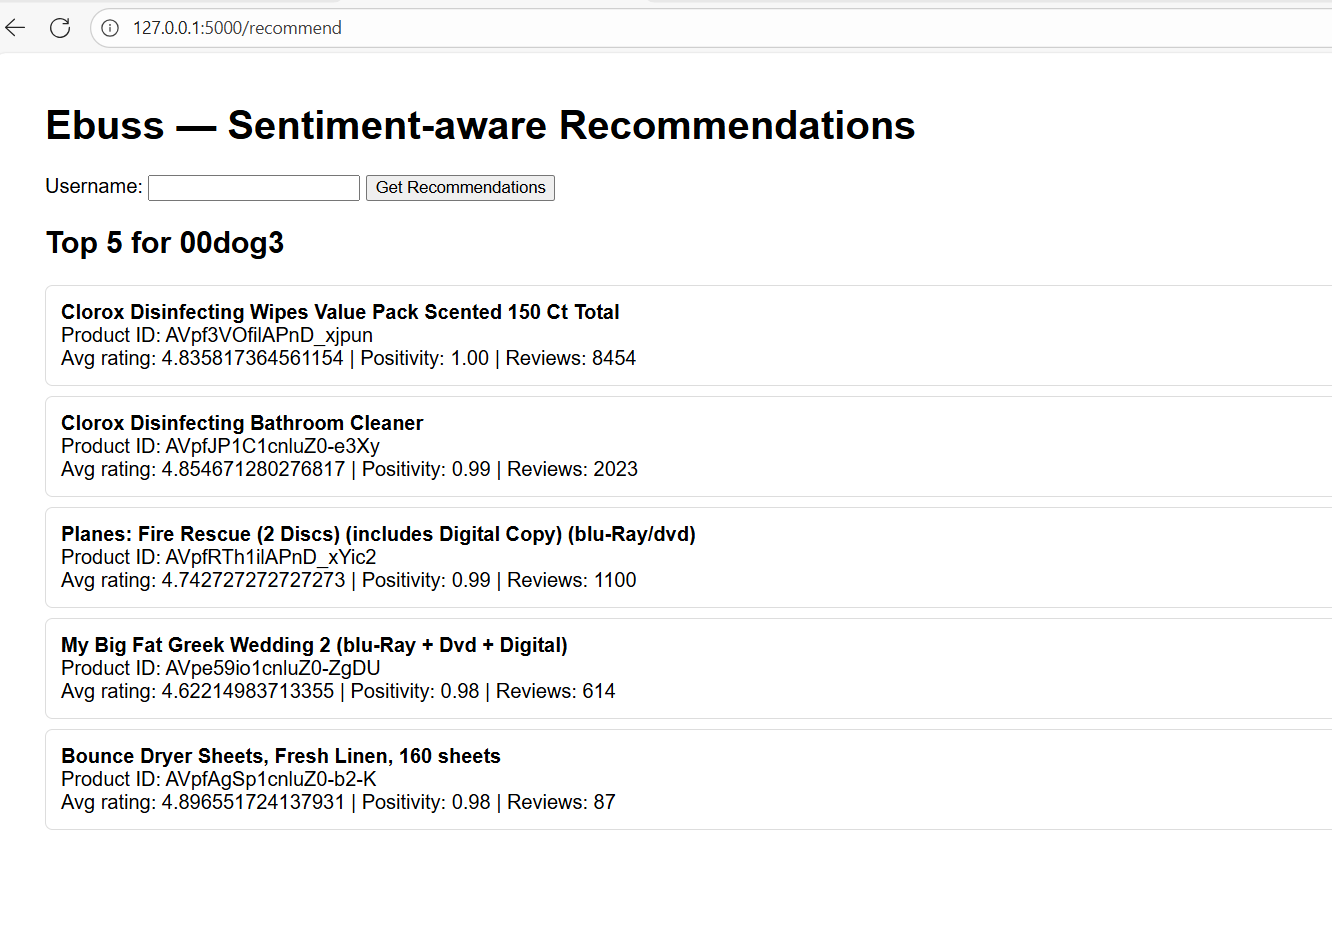